In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup as bs
import requests
from urllib.parse import urlparse

In [ ]:
#Added new column 'name'
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/new_data.csv')
df.head()

,website_url,cleaned_website_text,Category,name
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,booking
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,travelsites
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,travelsites
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,momondo
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,ebookers


<Axes: xlabel='count', ylabel='Category'>

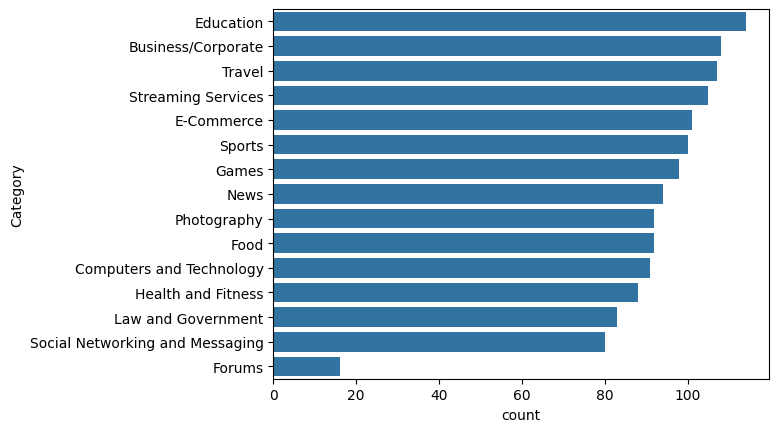

In [ ]:
sns.countplot(y=df['Category'],order=df['Category'].value_counts().index[:16])

In [ ]:
#Combine all website text and apply TF-IDF
combined = df['cleaned_website_text'].str.replace('|', ' ', regex = True)
tfidf = TfidfVectorizer()
f_v = tfidf.fit(combined)
tfidf_matrix = f_v.transform(combined)

#Label category
target = df['Category']
le = LabelEncoder()
target = le.fit_transform(target)

#Training data
x_train,x_test,y_train,y_test = train_test_split(tfidf_matrix,target,test_size=0.2, random_state=42)

#LinearSVC model
model = LinearSVC()
model.fit(x_train,y_train)
pred = model.predict(x_test)
acc = accuracy_score(y_test, pred)
print("SVC accuracy score: ",acc)

SVC accuracy score:  0.9379562043795621


In [ ]:
web = 'https://www.netflix.com/'
#Connection
try:
    r= requests.get(web).content
except:
    print("Connection Error!")

In [ ]:
#Website name through URL parser
name = "".join(urlparse(web).netloc.split(".")[-2])
soup = bs(r, "lxml")
#Finding all the tags scrapped
tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
#Content from tags
content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
tags = soup.find_all(["h1","h2","h3","h4","h5","h6"])
#Content from tags
text = [" ".join(tag.stripped_strings) for tag in tags]
content = ' '.join(content) + ' '.join(text)
print(content)

watch movies, movies online, watch TV, TV online, TV shows online, watch TV shows, stream movies, stream tv, instant streaming, watch online, movies, watch movies United States, watch TV online, no download, full length movies Watch Netflix movies & TV shows online or stream right to your smart TV, game console, PC, Mac, mobile, tablet and more.Unlimited movies, TV shows, and more Ready to watch? Enter your email to create or restart your membership. Enjoy on your TV Watch everywhere Create profiles for kids Download your shows to watch offline Frequently Asked Questions What is Netflix? How much does Netflix cost? Where can I watch? How do I cancel? What can I watch on Netflix? Is Netflix good for kids? Ready to watch? Enter your email to create or restart your membership.


In [ ]:
#Prediction for 'web'
t = f_v.transform([content])
pred = le.inverse_transform(model.predict(t))
print(pred[0])

Streaming Services


In [ ]:
#Pushing 'web' into df, if similar not found
is_match = (df['website_url'] == web).any()
if not is_match:
  df.loc[len(df.index)] = [web, content, pred[0], name]
  df.to_csv("/content/drive/MyDrive/Colab Notebooks/new_data.csv", index = False)
df.tail()

,website_url,cleaned_website_text,Category,name
1364,http://www.cleanridge.com/,clean ridge soap company clean ridge soap comp...,Business/Corporate,cleanridge
1365,http://www.creativepetgifts.com/,home page pet crafts exquisitely piece handcut...,Business/Corporate,creativepetgifts
1366,http://www.htmarket.com/,home theater marketplace home theater seating ...,Business/Corporate,htmarket
1367,https://thrivemarket.com/web/membership/welcome,thrive market healthy living easy buy healthy ...,Business/Corporate,thrivemarket
1368,https://www.netflix.com/,"watch movies, movies online, watch TV, TV onli...",Streaming Services,netflix


In [ ]:
#Applying cosine similarity for recommendation
cosine_similarity = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(cosine_similarity, index=df['website_url'], columns=df['website_url'])
index = similarity_df.index.get_loc(web)
top_10 = similarity_df.iloc[index].sort_values(ascending=False)[1:11]
print(f'Top 10 similar websites to {web}:')
print(top_10)

Top 10 similar websites to https://www.netflix.com/:
website_url
https://www.netflix.com/in/                            0.417082
https://spuul.com                                      0.280078
https://www.popcornflix.com/pages/discover/d/movies    0.262068
https://corporate.pluto.tv/                            0.224617
https://www.att.com/tv/                                0.223276
https://www.amebatv.com                                0.220662
https://tv.youtube.com/                                0.219965
https://flixtor.is/home                                0.199378
https://www.zee5.com/                                  0.195085
https://www.imdb.com/tv/                               0.191393
Name: https://www.netflix.com/, dtype: float64
